# Analysis of an `opsim4` run `des70_2012` and `des70_2013`

## Juypter boilerplate

### Basic notebook configuration

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Base python modules

In [2]:
import sys
import os

### Standard scientific python stuff

In [3]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy

### Set plotting style

In [4]:
mpl.rcParams['figure.figsize'] = (10, 5)
plt.style.use('ggplot')

### LSST specific modules

In [5]:
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'2.4.0.sims-13-gc7b79bd'

## Configuration

Set the random number seed so the notebook is strictly repeatable:

In [6]:
np.random.seed(6563)

Paths:

In [7]:
sim_db_path = '/home/docmaf/run_local/output'
base_results_path = '/home/docmaf/run_local/maf_results'

## Compare seeing histories of the new and default simulations

### Supporting code

Create a "year stacker" so I can use it to plot the seeing history with a scale of years:

In [8]:
class YearStacker(stackers.BaseStacker):
    """Calculate the floating point years into the survey."""
    def __init__(self):
        self.units = ['years']
        self.colsAdded = ['years_into_survey']
        self.colsReq = ['night']
        
    def run(self, simData):
        """Calculate new column years into the survey."""
        simData=self._addStackers(simData)
        simData['years_into_survey'] = simData['night'].astype(float)/365.24
        return simData

Create a procedure for plotting the seeing with time:

In [9]:
def plot_seeing_vs_year(dbname):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    seeing_metric = metrics.MeanMetric('seeingFwhm500')
    year_slicer = slicers.OneDSlicer('years_into_survey', 'years', 12*10)
    mean_seeing = metricBundles.MetricBundle(seeing_metric, year_slicer, stackerList=[YearStacker()])
    mean_seeing_bundle = {'mean_seeing': mean_seeing}
    mean_seeing_group = metricBundles.MetricBundleGroup(mean_seeing_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    mean_seeing_group.runAll()
    
    mean_seeing_group.plotAll(closefigs=False)

### Base simulation seeing history

Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2364976 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


Text(0.5,1,'des70_2001 (default)')

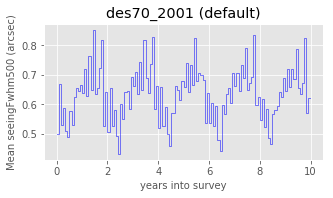

In [50]:
mpl.rcParams['figure.figsize'] = (5, 2.5)
plot_seeing_vs_year('des70_2001')
plt.xlabel('years into survey')
plt.title('des70_2001 (default)')

### Simulation with remodeled seeing

Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2334980 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


Text(0.5,1,'des70_2012 (DIMM 2008-2017)')

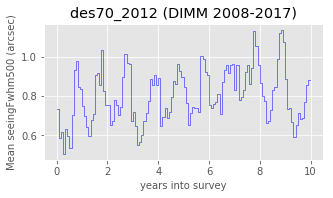

In [51]:
plot_seeing_vs_year('des70_2012')
plt.xlabel('years into survey')
plt.title('des70_2012 (DIMM 2008-2017)')

Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2341351 visits
Running:  ['mean_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.


Text(0.5,1,'des70_2013 (DIMM 2005-2014)')

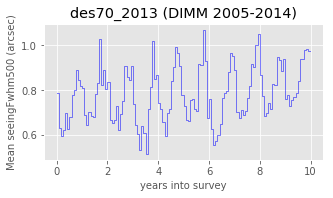

In [53]:
plot_seeing_vs_year('des70_2013')
plt.xlabel('years into survey')
plt.title('des70_2013 (DIMM 2005-2014)')

## Map the seeing in the different simulations

### Supporting code

#### Hacked version of HealpixSkyMap that allows specification of the color limits

The structure of the class doesn't lend itself to modification through subclassing, so I need to just copy most of the code.

In [152]:
class HealpixSkyMap(plots.spatialPlotters.BasePlotter):
    """
    Generate a sky map of healpix metric values using healpy's mollweide view.
    """
    def __init__(self, clims=None):
        super(HealpixSkyMap, self).__init__()
        # Set the plotType
        self.clims = clims
        self.plotType = 'SkyMap'
        self.objectPlotter = False
        # Set up the default plotting parameters.
        self.defaultPlotDict = {}
        self.defaultPlotDict.update(plots.spatialPlotters.baseDefaultPlotDict)
        self.defaultPlotDict.update({'rot': (0, 0, 0), 'coord': 'C'})

    def __call__(self, metricValueIn, slicer, userPlotDict, fignum=None):
        """
        Parameters
        ----------
        metricValue : numpy.ma.MaskedArray
        slicer : lsst.sims.maf.slicers.HealpixSlicer
        userPlotDict: dict
            Dictionary of plot parameters set by user (overrides default values).
        fignum : int
            Matplotlib figure number to use (default = None, starts new figure).

        Returns
        -------
        int
           Matplotlib figure number used to create the plot.
        """
        # Override the default plotting parameters with user specified values.
        plotDict = {}
        plotDict.update(self.defaultPlotDict)
        plotDict.update(userPlotDict)
        # Update the metric data with zeropoint or normalization.
        metricValue = plots.spatialPlotters.applyZPNorm(metricValueIn, plotDict)
        # Generate a Mollweide full-sky plot.
        fig = plt.figure(fignum, figsize=plotDict['figsize'])
        # Set up color bar limits.
        clims = plots.spatialPlotters.setColorLims(metricValue, plotDict) if self.clims is None else self.clims
        cmap = plots.spatialPlotters.setColorMap(plotDict)
        # Set log scale?
        norm = None
        if plotDict['logScale']:
            norm = 'log'
        # Avoid trying to log scale when zero is in the range.
        if (norm == 'log') & ((clims[0] <= 0 <= clims[1]) or (clims[0] >= 0 >= clims[1])):
            # Try something simple
            above = metricValue[np.where(metricValue > 0)]
            if len(above) > 0:
                clims[0] = above.max()
            # If still bad, give up and turn off norm
            if ((clims[0] <= 0 <= clims[1]) or (clims[0] >= 0 >= clims[1])):
                norm = None
            plots.spatialPlotters.warnings.warn("Using norm was set to log, but color limits pass through 0. "
                          "Adjusting so plotting doesn't fail")

        plots.spatialPlotters.hp.mollview(metricValue.filled(slicer.badval), title=plotDict['title'], cbar=False,
                    min=clims[0], max=clims[1], rot=plotDict['rot'], flip='astro',
                    coord=plotDict['coord'], cmap=cmap, norm=norm,
                    sub=plotDict['subplot'], fig=fig.number)
        # Add a graticule (grid) over the globe.
        plots.spatialPlotters.hp.graticule(dpar=30, dmer=30, verbose=False)
        # Add colorbar (not using healpy default colorbar because we want more tickmarks).
        ax = plt.gca()
        im = ax.get_images()[0]
        # Add label.
        if plotDict['label'] is not None:
            plt.figtext(0.8, 0.8, '%s' % (plotDict['label']))
        # Make a color bar. Supress silly colorbar warnings.
        with plots.spatialPlotters.warnings.catch_warnings():
            plots.spatialPlotters.warnings.simplefilter("ignore")
            cb = plt.colorbar(im, shrink=0.75, aspect=25, pad=0.1, orientation='horizontal',
                              format=plotDict['cbarFormat'], extendrect=True)
            cb.set_label(plotDict['xlabel'], fontsize=plotDict['fontsize'])
            if plotDict['labelsize'] is not None:
                cb.ax.tick_params(labelsize=plotDict['labelsize'])
            if norm == 'log':
                tick_locator = plots.spatialPlotters.ticker.LogLocator(numticks=plotDict['nTicks'])
                cb.locator = tick_locator
                cb.update_ticks()
            if (plotDict['nTicks'] is not None) & (norm != 'log'):
                tick_locator = plots.spatialPlotters.ticker.MaxNLocator(nbins=plotDict['nTicks'])
                cb.locator = tick_locator
                cb.update_ticks()
        # If outputing to PDF, this fixes the colorbar white stripes
        if plotDict['cbar_edge']:
            cb.solids.set_edgecolor("face")
        return fig.number


#### Function to do the plot itself

In [158]:
def map_seeing(dbname,
              sql_constraint = 'filter = "i" AND proposalId=3',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('seeingFwhmEff')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'seeingFwhmEff': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()
    
    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.seeingFwhmEff.describe())
    
    metric_group.bundleDict['seeingFwhmEff'].setPlotFuncs([HealpixSkyMap(clims=[0.75,1.2])])
    metric_group.plotAll(closefigs=False)

### Base simulation FWHM map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 444817 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444817.000000
mean          0.858629
std           0.184589
min           0.484656
25%           0.727346
50%           0.829340
75%           0.959636
max           1.899399
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


Text(0.5,1,'des70_2001 (default)')

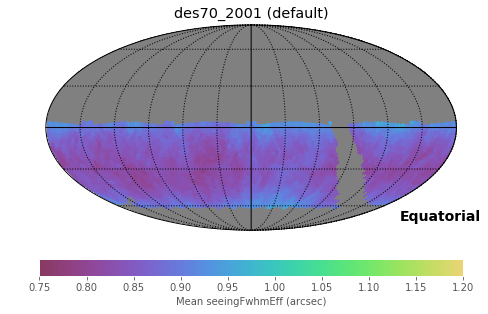

In [159]:
mpl.rcParams['figure.figsize'] = (8, 4)
map_seeing('des70_2001')
plt.title('des70_2001 (default)')

### Remodeled seeing FWHM map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 437752 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    437752.000000
mean          0.977455
std           0.237913
min           0.469250
25%           0.797537
50%           0.933535
75%           1.115433
max           2.726817
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


Text(0.5,1,'des70_2012 (DIMM 2008-2017)')

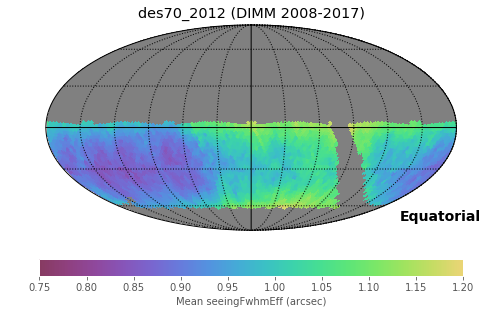

In [161]:
map_seeing('des70_2012')
plt.title('des70_2012 (DIMM 2008-2017)')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 438999 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    438999.000000
mean          0.968397
std           0.245194
min           0.470256
25%           0.780565
50%           0.922020
75%           1.116746
max           2.709761
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


Text(0.5,1,'des70_2013 (DIMM 2005-2014)')

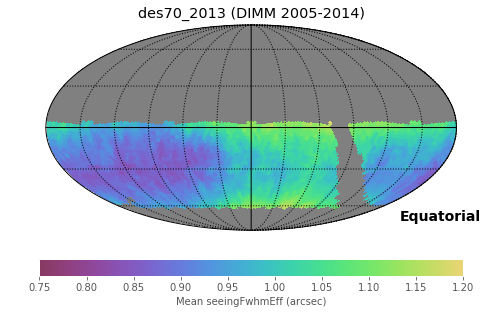

In [163]:
map_seeing('des70_2013')
plt.title('des70_2013 (DIMM 2005-2014)')

## Compare the depths of the different simulations

### Supporting code

In [172]:
def map_depth(dbname,
              sql_constraint = 'filter = "i" AND proposalId=3',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('fiveSigmaDepth')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'depth': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()

    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.fiveSigmaDepth.describe())

    metric_group.bundleDict['depth'].setPlotFuncs([HealpixSkyMap(clims=[23.2,23.85])])
    metric_group.plotAll(closefigs=False)

### Base simulation depth map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 444817 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    444817.000000
mean         23.668003
std           0.258342
min          22.533697
25%          23.500659
50%          23.683083
75%          23.849958
max          24.382914
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


Text(0.5,1,'des70_2001 (default)')

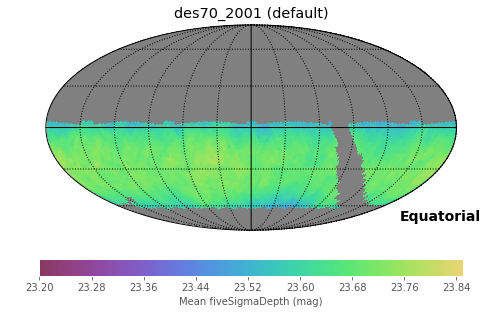

In [176]:
map_depth('des70_2001')
plt.title('des70_2001 (default)')

### Remodeled seeing depth map

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 437752 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    437752.000000
mean         23.535628
std           0.291863
min          22.363525
25%          23.333517
50%          23.550034
75%          23.753759
max          24.398992
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


Text(0.5,1,'des70_2012 (DIMM 2008-2017)')

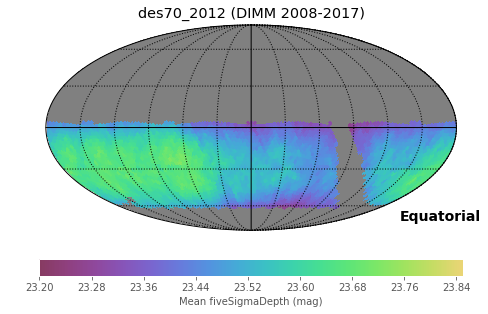

In [177]:
map_depth('des70_2012')
plt.title('des70_2012 (DIMM 2008-2017)')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 438999 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    438999.000000
mean         23.549388
std           0.298824
min          22.306386
25%          23.343629
50%          23.564600
75%          23.769396
max          24.410374
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i" AND proposalId=3" constraint now.
Plotting complete.


Text(0.5,1,'des70_2013 (DIMM 2005-2014)')

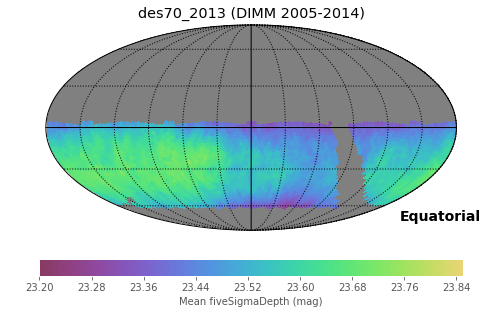

In [178]:
map_depth('des70_2013')
plt.title('des70_2013 (DIMM 2005-2014)')

## Plotting depth and seeing with field R.A.

### Support code

Load data into `pandas.DataFrame`s.

In [25]:
def load_df(dbname,
            metric_columns = ['seeingFwhmEff', 'fiveSigmaDepth'],
            slice_column = 'fieldRA',
            sql_constraint = 'filter = "i" AND proposalId=3',
            agg_metric=metrics.MeanMetric):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    slicer_for_df = slicers.OneDSlicer(slice_column)
    metric_bundle = {col: metricBundles.MetricBundle(agg_metric(col), slicer_for_df, sql_constraint)
                     for col in metric_columns}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    metric_group.runAll()
    df = pd.DataFrame.from_records(metric_group.simData)
    df.sort_values('fieldRA', inplace=True)
    df['hour'] = np.floor(df.fieldRA/15).astype(np.int32)
    return df

### Load the data

In [29]:
see_by_ra = {2001: load_df('des70_2001'),
             2012: load_df('des70_2012'),
             2013: load_df('des70_2013')}

Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['seeingFwhmEff', 'fieldRA', 'fiveSigmaDepth']
Found 444817 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 4.655531 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['seeingFwhmEff', 'fieldRA', 'fiveSigmaDepth']
Found 437752 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 4.716788 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND proposalId=3 for columns ['seeingFwhmEff', 'fieldRA', 'fiveSigmaDepth']
Found 438999 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Plot depth against R.A.

Text(0,0.5,'mean 5$\\sigma$ depth')

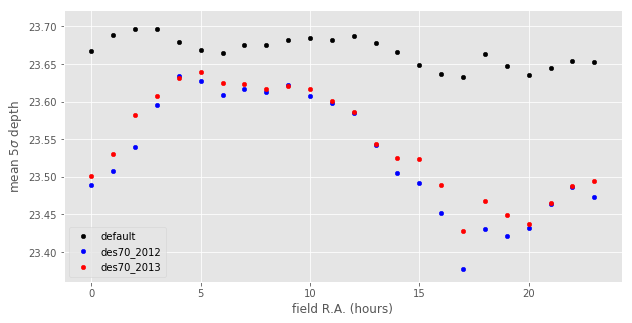

In [33]:
fig, axes = plt.subplots()
legend_label = {2001: 'default', 2012: 'des70_2012', 2013: 'des70_2013'}
point_color = {2001: 'k', 2012: 'b', 2013: 'r'}
for idx in (2001, 2012, 2013):
    df = see_by_ra[idx]
    label = legend_label[idx]
    color = point_color[idx]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean 5$\sigma$ depth')

What is the difference between the base and the revisions?

In [34]:
print("Difference between base and des70_2012 seeing: ",
     np.round(see_by_ra[2001].fiveSigmaDepth.mean()-see_by_ra[2012].fiveSigmaDepth.mean(), 2))
print("Difference between base and des70_2012 seeing: ",
     np.round(see_by_ra[2001].fiveSigmaDepth.mean()-see_by_ra[2013].fiveSigmaDepth.mean(), 2))

Difference between base and des70_2012 seeing:  0.13
Difference between base and des70_2012 seeing:  0.12


What's the difference between the worst and best sets of months?

In [35]:
print('Difference in base: ', np.round(see_by_ra[2001].query('4 <= hour <= 9').fiveSigmaDepth.mean() - see_by_ra[2001].query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))
print('Difference in des70_2012: ', np.round(see_by_ra[2012].query('4 <= hour <= 9').fiveSigmaDepth.mean() - see_by_ra[2012].query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))
print('Difference in des70_2013: ', np.round(see_by_ra[2013].query('4 <= hour <= 9').fiveSigmaDepth.mean() - see_by_ra[2013].query('16 <= hour <= 21').fiveSigmaDepth.mean(), 2))

Difference in base:  0.03
Difference in des70_2012:  0.19
Difference in des70_2013:  0.17


What are these in decimal degrees?

In [38]:
np.array([4, 9+1, 16, 21+1])*15

array([ 60, 150, 240, 330])

### Plot delivered FWHM against R.A.

Text(0,0.5,'mean seeingFwhmEff')

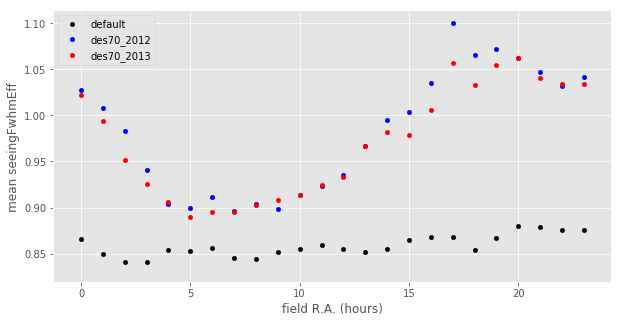

In [37]:
fig, axes = plt.subplots()
legend_label = {2001: 'default', 2012: 'des70_2012', 2013: 'des70_2013'}
point_color = {2001: 'k', 2012: 'b', 2013: 'r'}
for idx in (2001, 2012, 2013):
    df = see_by_ra[idx]
    label = legend_label[idx]
    color = point_color[idx]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean seeingFwhmEff')

In [39]:
print("Difference between base and des70_2012 seeing: ",
     np.round((see_by_ra[2001].seeingFwhmEff.mean()-see_by_ra[2012].seeingFwhmEff.mean())/see_by_ra[2001].seeingFwhmEff.mean(), 2))
print("Difference between base and des70_2013 seeing: ",
     np.round((see_by_ra[2001].seeingFwhmEff.mean()-see_by_ra[2013].seeingFwhmEff.mean())/see_by_ra[2001].seeingFwhmEff.mean(), 2))

Difference between base and des70_2012 seeing:  -0.14
Difference between base and des70_2013 seeing:  -0.13


In [41]:
print('Difference in base: ', np.round( (see_by_ra[2001].query('16 <= hour <= 22').seeingFwhmEff.mean() - see_by_ra[2001].query('4 <= hour <= 10').seeingFwhmEff.mean())/see_by_ra[2001].query('4 <= hour <= 10').seeingFwhmEff.mean(), 2))
print('Difference in des70_2012 simulation: ', np.round( (see_by_ra[2012].query('16 <= hour <= 22').seeingFwhmEff.mean() - see_by_ra[2012].query('4 <= hour <= 10').seeingFwhmEff.mean())/see_by_ra[2012].query('4 <= hour <= 10').seeingFwhmEff.mean(), 2))
print('Difference in des70_2013 simulation: ', np.round( (see_by_ra[2012].query('16 <= hour <= 22').seeingFwhmEff.mean() - see_by_ra[2013].query('4 <= hour <= 10').seeingFwhmEff.mean())/see_by_ra[2013].query('4 <= hour <= 10').seeingFwhmEff.mean(), 2))

Difference in base:  0.02
Difference in des70_2012 simulation:  0.17
Difference in des70_2013 simulation:  0.17
